# Computation of the scattering cross section of a resonant square

Nuno de Sousa

In [21]:
%matplotlib notebook

import numpy as np
import ipyvolume as ipv
import scipy
from datetime import datetime
import sys

sys.path.insert(0, "../")

import mole_geometries.Geom as Geom
import mole_mie.Materials as Materials
import mole_dda.CrossSections as cs


import matplotlib.pyplot as plt

In [13]:
def square_geom(Nx, Ny, a):
    """
    :param: a -> lattice parameter
    """
    
    positions = []
    
    for i in range(Nx+1):
        for j in range(Ny+1):
            positions.append([i*a-Nx*a/2, j*a-Ny*a/2, 0])
            
    return np.array(positions)

pos = square_geom(10,10,2)

<IPython.core.display.Javascript object>


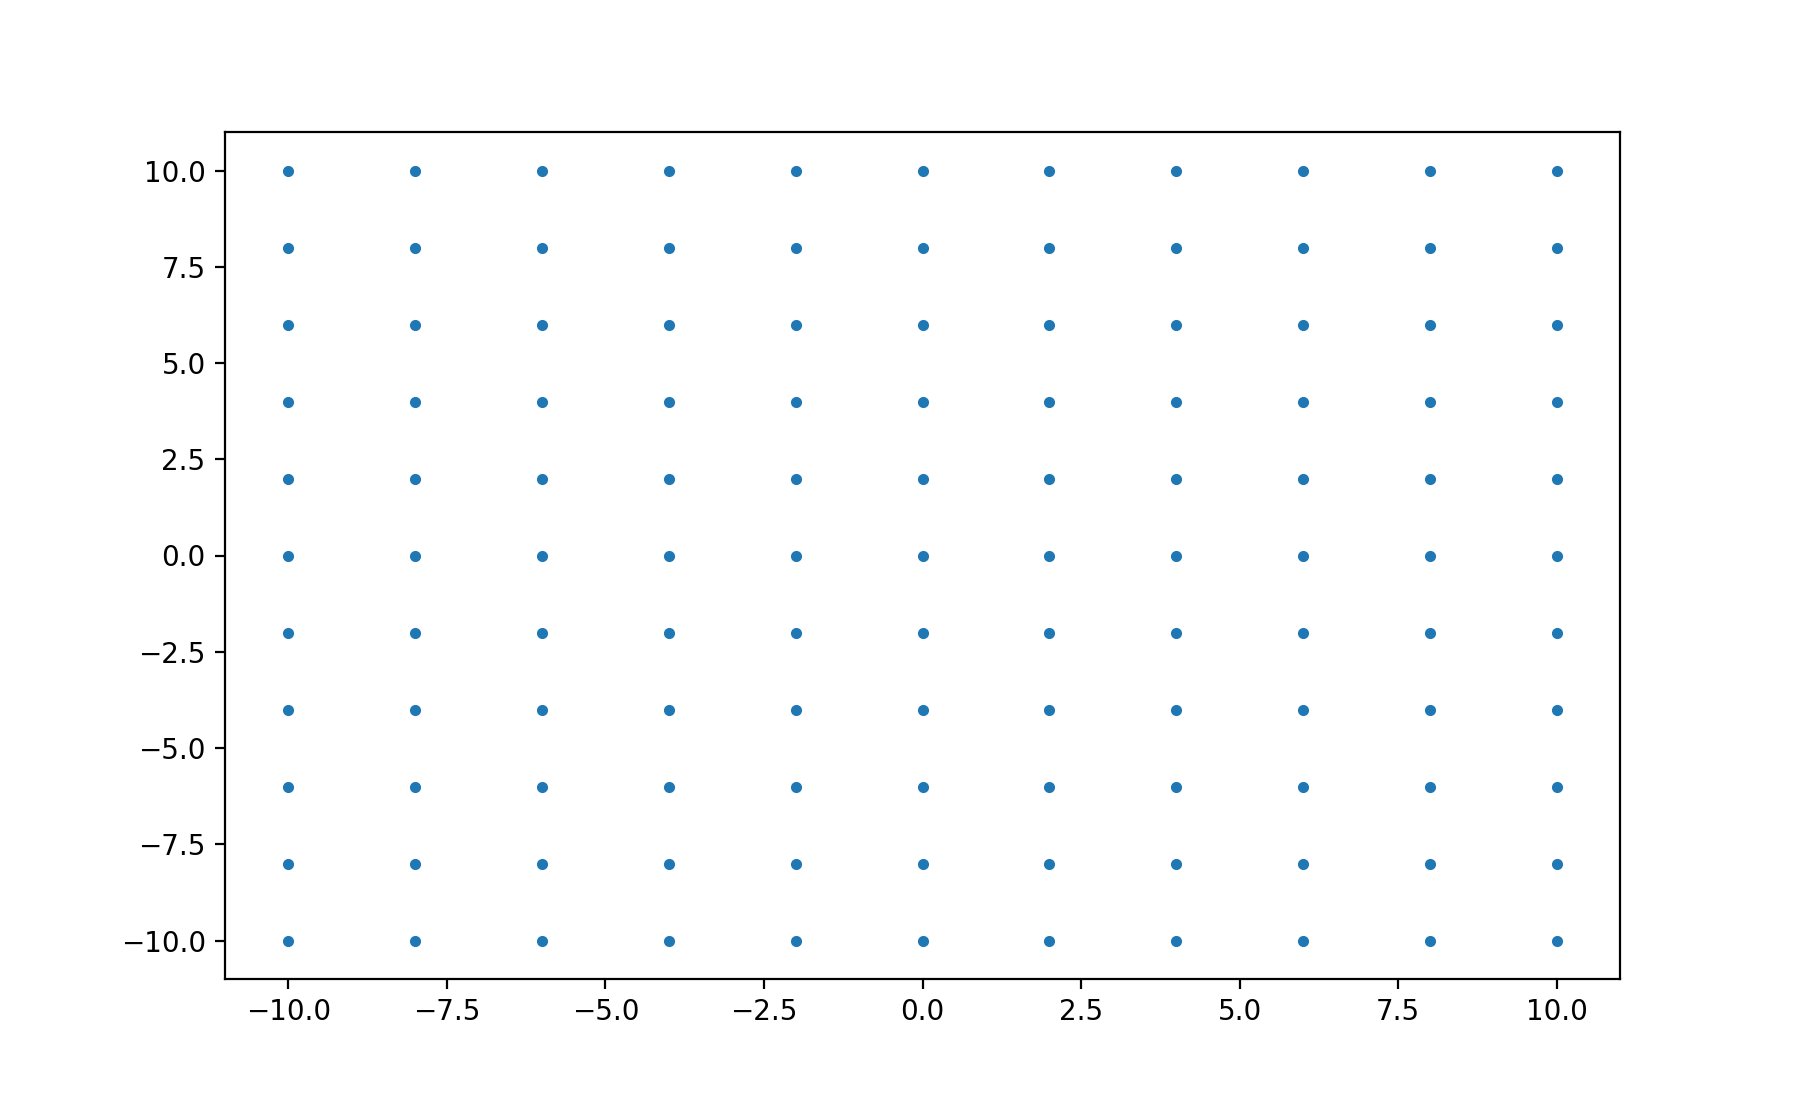

In [15]:
fig = plt.figure(figsize = (9, 5.5))

plt.plot(pos[:,0], pos[:,1], marker = '.', linestyle = '')

In [16]:
class DDA(object):
    
    SGreenTensor = None
    
    def __init__(self):
        pass
    
    def SGreenTensorE_compute(self, positions, k, alpha, epsilon_m = 1, return_f = True):
        np.seterr(divide='ignore', invalid='ignore')

        N_particles = positions.shape[0]

        G = np.zeros((N_particles, 3, N_particles, 3), dtype=complex)

        i, x_i, j, x_j = np.mgrid[0:N_particles, 0:3, 0:N_particles, 0:3]
        G[np.where((i == j) & (x_i == x_j))] = 1
        R = np.linalg.norm(positions[None, :, :] - positions[:, None, :], axis=-1)
        R = R.reshape(N_particles, 1, N_particles, 1)

        r = positions[None, :, :] - positions[:, None, :]

        krq = (k * R) ** 2
        pf = -k ** 2 / (epsilon_m) * alpha * np.exp(1j * k * R) / (4 * np.pi * R)
        a = 1. + (1j * k * R - 1.) / (krq)
        b = (3. - 3. * 1j * k * R - krq) / (krq)

        comb_r = (r[:, :, :, None] * r[:, :, None, :]).transpose([0, 2, 1, 3])
        G = pf * (b * comb_r / (R ** 2))
        G[np.where(x_i == x_j)] = (G + pf * a)[np.where(x_i == x_j)]
        G[np.where(i == j)] = 0
        G[np.where((i == j) & (x_i == x_j))] = 1

        self.GreenTensor = G.reshape(N_particles * 3, N_particles * 3)
        
        if(return_f == True):
            return self.GreenTensor


class Ilumination(object):

    """
    Ilumination
    ===========
    """

    @staticmethod
    def plane_wave(k, E0_const, positions, k_inc = 'z'):
        """
        Plane Wave generator. This function generates the field experienced by a particle at some position in space.
        The wave must have a constant that characterizes the electric field (E0_const), the wave number and wave vector
        (k and k_inc).
        :param k: (float) Wavenumber
        :param positions: (np.array) positions of the particle
        :param E0_const:(float) Electric Field constant
        :param k_inc: direction of the wave vector
        :return: (np.array) Electric field in each particle with two different polarizations (sorted by x, y, z)
        """

        N_particles = positions.shape[0]

        if(k_inc == 'z'):
            kvector =k*np.array([0, 0, 1])
            Ex = np.zeros((N_particles,3),dtype=complex)
            Ey = np.zeros((N_particles,3),dtype=complex)
            i,x_i = np.mgrid[0:N_particles,0:3]
            j,y_j = np.mgrid[0:N_particles,0:3]
            Ex[np.where((x_i == 0))] = E0_const*np.exp(1j*np.array([np.dot(kvector,i) for i in positions]))
            Ey[np.where((y_j == 1))] = E0_const*np.exp(1j*np.array([np.dot(kvector,j) for j in positions]))
            Ex = Ex.reshape(3*N_particles)
            Ey = Ey.reshape(3*N_particles)
            E = np.transpose(np.vstack([Ex,Ey]))

        if(k_inc == 'y'):
            kvector =k*np.array([0, 1, 0])
            Ex = np.zeros((N_particles,3),dtype=complex)
            Ez = np.zeros((N_particles,3),dtype=complex)
            i,x_i = np.mgrid[0:N_particles,0:3]
            j,z_j = np.mgrid[0:N_particles,0:3]
            Ex[np.where((x_i == 0))] = E0_const*np.exp(1j*np.array([np.dot(kvector,i) for i in positions]))
            Ez[np.where((z_j == 2))] = E0_const*np.exp(1j*np.array([np.dot(kvector,j) for j in positions]))
            Ex = Ex.reshape(3*N_particles)
            Ez = Ez.reshape(3*N_particles)
            E = np.transpose(np.vstack([Ex,Ez]))

        if(k_inc == 'x'):
            kvector =k*np.array([1, 0, 0])
            Ey = np.zeros((N_particles,3),dtype=complex)
            Ez = np.zeros((N_particles,3),dtype=complex)
            i,y_i = np.mgrid[0:N_particles,0:3]
            j,z_j = np.mgrid[0:N_particles,0:3]
            Ex[np.where((y_i == 1))] = E0_const*np.exp(1j*np.array([np.dot(kvector,i) for i in positions]))
            Ey[np.where((z_j == 2))] = E0_const*np.exp(1j*np.array([np.dot(kvector,j) for j in positions]))
            Ey = Ey.reshape(3*N_particles)
            Ez = Ez.reshape(3*N_particles)
            E = np.transpose(np.vstack([Ey,Ez]))

        return E

In [17]:
lam = 1
k = 2*np.pi/lam
alpha = 1j*6*np.pi/k**3
dda = DDA()

SG = dda.SGreenTensorE_compute(positions = pos, k = k, epsilon_m = 1, alpha = alpha)

In [18]:
E_inc = Ilumination.plane_wave(k = k, E0_const = 1 , positions = pos, k_inc = 'z')

In [19]:
%time E_i = scipy.linalg.solve(SG, E_inc)

CPU times: user 33 ms, sys: 4.83 ms, total: 37.8 ms
Wall time: 8.12 ms


In [31]:
def sigma_ext_calc(epsilon_m, k, alpha, E0_const, E_0i, E_inc, epsilon_0 = 1, return_f = False):
    """
    It Computes the Extintion Cross Section.
    
    :param: epsilon_m = dielectric constant of the medium
    :param: k = wavenumber in free space
    :param: alpha = polarizability of the particles (it is a scalar)
    :param: E0_const = Magnitud of the electric field
    :param: epsilon_0 = dielectric permitivity of vacuum.
    :return: return_f = (True or False), if True returns a vector with the sigma_ext, 
    otherwise it only writes in the class.
    """
    p = epsilon_0 * epsilon_m * alpha * E_inc

    sigma_ext = np.diagonal(
            k / (epsilon_0 * epsilon_m * E0_const ** 2) * np.imag(np.dot(np.conjugate(np.transpose(E_0i)), p)))
    if (return_f == True):
        return sigma_ext

In [32]:
sigma_ext_calc(epsilon_m = 1, k = k, alpha = alpha, E0_const = 1, E_0i = Ei, E_inc, epsilon_0 = 1, return_f = False)

array([[1.+0.j, 0.+0.j],
       [0.+0.j, 1.+0.j],
       [0.+0.j, 0.+0.j],
       [1.+0.j, 0.+0.j],
       [0.+0.j, 1.+0.j],
       [0.+0.j, 0.+0.j],
       [1.+0.j, 0.+0.j],
       [0.+0.j, 1.+0.j],
       [0.+0.j, 0.+0.j],
       [1.+0.j, 0.+0.j],
       [0.+0.j, 1.+0.j],
       [0.+0.j, 0.+0.j],
       [1.+0.j, 0.+0.j],
       [0.+0.j, 1.+0.j],
       [0.+0.j, 0.+0.j],
       [1.+0.j, 0.+0.j],
       [0.+0.j, 1.+0.j],
       [0.+0.j, 0.+0.j],
       [1.+0.j, 0.+0.j],
       [0.+0.j, 1.+0.j],
       [0.+0.j, 0.+0.j],
       [1.+0.j, 0.+0.j],
       [0.+0.j, 1.+0.j],
       [0.+0.j, 0.+0.j],
       [1.+0.j, 0.+0.j],
       [0.+0.j, 1.+0.j],
       [0.+0.j, 0.+0.j],
       [1.+0.j, 0.+0.j],
       [0.+0.j, 1.+0.j],
       [0.+0.j, 0.+0.j],
       [1.+0.j, 0.+0.j],
       [0.+0.j, 1.+0.j],
       [0.+0.j, 0.+0.j],
       [1.+0.j, 0.+0.j],
       [0.+0.j, 1.+0.j],
       [0.+0.j, 0.+0.j],
       [1.+0.j, 0.+0.j],
       [0.+0.j, 1.+0.j],
       [0.+0.j, 0.+0.j],
       [1.+0.j, 0.+0.j],
